In [1]:
import torch
import qadence
import graphviz
import numpy as np

INFO  2025-01-12 11:03:16 - pyqtorch: PyQTorch logger successfully setup with log level 20
2025-01-12 11:03:18.763434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-12 11:03:18.780549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-12 11:03:18.780606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 11:03:18.793146: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlo

In [2]:
def calc_second_deriv(outputs: torch.Tensor, inputs: torch.Tensor, idx: int) -> torch.Tensor:
    """Compute a derivative of model that learns f(x), computes df/dx using torch.autograd."""
    first_grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(outputs),
        create_graph = True,
        retain_graph = True,
    )[0][:, idx]

    second_grad = torch.autograd.grad(
        outputs=first_grad,
        inputs=inputs,
        grad_outputs = torch.ones_like(first_grad),
        create_graph = True,
        retain_graph = True,
    )[0][:, idx]
    return second_grad

In [3]:
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
	x = inputs[:, 0]
	y = inputs[:, 1]
	
	model_output = model(inputs)
	second_deriv_x = calc_second_deriv(model_output, inputs, idx=0)
	second_deriv_y = calc_second_deriv(model_output, inputs, idx=1)
	
	pde_loss = criterion(second_deriv_x + second_deriv_y, torch.zeros_like(second_deriv_x))

	boundary_x0_model = model({'x': torch.zeros_like(x), 'y': y})
	boundary_x1_model = model({'x': torch.ones_like(x), 'y': y})
	boundary_y0_model = model({'x': inputs[:, 0:1], 'y': torch.zeros_like(y)})
	boundary_y1_model = model({'x': inputs[:, 0:1], 'y': torch.ones_like(y)})

	boundary_x0_exact = torch.sin(torch.pi * y)
	boundary_x1_exact = np.exp(-torch.pi) * torch.sin(torch.pi * y)
	boundary_y0_exact = torch.zeros_like(x)
	boundary_y1_exact = torch.zeros_like(x)
	
	boundary_loss = (
		criterion(boundary_x0_model, boundary_x0_exact) +
		criterion(boundary_x1_model, boundary_x1_exact) +
		criterion(boundary_y0_model, boundary_y0_exact) +
		criterion(boundary_y1_model, boundary_y1_exact)
	)

	print(f'Loss: {pde_loss + boundary_loss}')

	return pde_loss + boundary_loss

In [4]:
from qadence import FeatureMapConfig, hea, chain, create_fm_blocks, ObservableConfig, AnsatzConfig
from qadence import AnsatzType, Strategy, create_ansatz, BackendName, DiffMode
from qadence import QNN, QuantumCircuit, Z
from qadence.types import BasisSet, ReuploadScaling

torch.manual_seed(42)

n_qubits = 4
depth = 8
n_epochs = 400
n_points = 20

x = torch.randn(n_points, 1)
y = torch.randn(n_points, 1)

fm_config = FeatureMapConfig(
	num_features=2,
	inputs=["x", "y"],
	basis_set=BasisSet.CHEBYSHEV,
	reupload_scaling=ReuploadScaling.TOWER,
	feature_range={
		"x": (-1, 1),
		"y": (-1, 1),
	}
)

observable_config = ObservableConfig(
    detuning=Z,
    scale=3.0,
    shift=-1.0,
)

fm_blocks = create_fm_blocks(config=fm_config, register=n_qubits)
fm = chain(*fm_blocks)

ansatz_config = AnsatzConfig(
	depth=depth,
	ansatz_type=AnsatzType.HEA,
	ansatz_strategy=Strategy.DIGITAL
)

ansatz = create_ansatz(config=ansatz_config, register=n_qubits)

model = QNN.from_configs(
	register=n_qubits,
	fm_config=fm_config,
	obs_config=observable_config,
	ansatz_config=ansatz_config,
	backend=BackendName.PYQTORCH,
	diff_mode=DiffMode.AD
)

In [5]:
xmin = 0
xmax = 0.99
ymin = 0
ymax = 0.99

# lr, depth, qubits, epochs, points

optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

x_train = torch.rand((n_points, 1), requires_grad=True)
y_train = torch.rand((n_points, 1), requires_grad=True)

train_data = torch.cat([x_train, y_train], dim=1)

for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = loss_fn(model=model, inputs=train_data)
    loss.backward()
    optimizer.step()

/home/avinashc/.local/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/avinashc/.local/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 957.7213706626716
Loss: 688.2808770019856
Loss: 1502.5754347591098
Loss: 1065.4308276836045
Loss: 207.18553978777172
Loss: 927.6648358108492
Loss: 386.35274351231124
Loss: 128.95837959030302
Loss: 482.1986857479557
Loss: 138.31058414897768
Loss: 100.22794422782853
Loss: 335.60117815429135
Loss: 271.5707495726978
Loss: 99.85604541267344
Loss: 136.72912565910855
Loss: 233.41053501270028
Loss: 143.53427809935997
Loss: 23.4738918348615
Loss: 49.359144819085365
Loss: 122.887951846966
Loss: 121.44240703075448
Loss: 67.07733034153773
Loss: 32.38547577967457
Loss: 35.18453520458895
Loss: 44.15265571353696
Loss: 35.2530052482683
Loss: 17.85158516828682
Loss: 16.77513120839765
Loss: 33.9479771034995
Loss: 41.37060516908705
Loss: 27.811167764287195
Loss: 14.880764120064955
Loss: 16.510115197733803
Loss: 22.299494641619965
Loss: 19.1465562984853
Loss: 8.792456277263863
Loss: 3.6682716142379364
Loss: 8.485243882348795
Loss: 13.08587683152825
Loss: 9.841295733764898
Loss: 5.372894752118826
Los

In [6]:
n_epochs2 = 200
loss = 100

while loss > 0.15:
    optimizer.zero_grad()
    loss = loss_fn(model=model, inputs=train_data)
    loss.backward()
    optimizer.step()

Loss: 0.28951810196908145
Loss: 0.28923670618435676
Loss: 0.28895593722907154
Loss: 0.28867579511702945
Loss: 0.2883962798448957
Loss: 0.2881173913918534
Loss: 0.2878391297194849
Loss: 0.2875614947722702
Loss: 0.2872844864780446
Loss: 0.2870081047478711
Loss: 0.2867323494758251
Loss: 0.28645722053926653
Loss: 0.2861827177993317
Loss: 0.28590884110101344
Loss: 0.28563559027295965
Loss: 0.28536296512758047
Loss: 0.2850909654614643
Loss: 0.28481959105560456
Loss: 0.2845488416752944
Loss: 0.2842787170701102
Loss: 0.28400921697423503
Loss: 0.2837403411067453
Loss: 0.2834720891716214
Loss: 0.28320446085767875
Loss: 0.28293745583879293
Loss: 0.28267107377420536
Loss: 0.2824053143086033
Loss: 0.2821401770720932
Loss: 0.28187566168031475
Loss: 0.28161176773472857
Loss: 0.28134849482277097
Loss: 0.28108584251784585
Loss: 0.2808238103794041
Loss: 0.2805623979531667
Loss: 0.28030160477132743
Loss: 0.2800414303525915
Loss: 0.27978187420221845
Loss: 0.2795229358122114
Loss: 0.27926461466151975
Loss:

/home/avinashc/.local/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Locator attempting to generate 1001 ticks ([0.0, ..., 1.0]), which exceeds Locator.MAXTICKS (1000).
/tmp/ipykernel_210989/478268110.py:15: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(y_test, x_test, result_exact, levels=1000, cmap="jet", alpha=0.7, label="Exact")


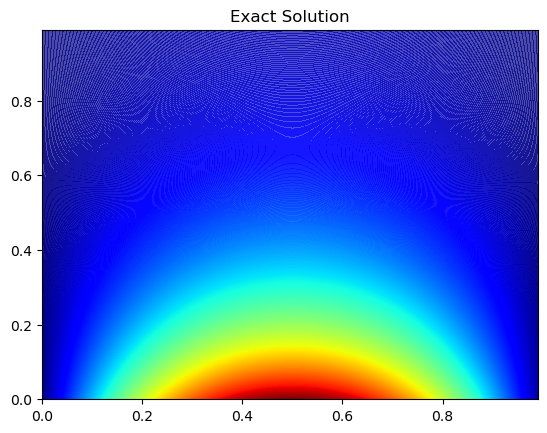

/tmp/ipykernel_210989/478268110.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(x_test, y_test, result_model, levels=1000, cmap="jet", alpha=0.7, label="Model")


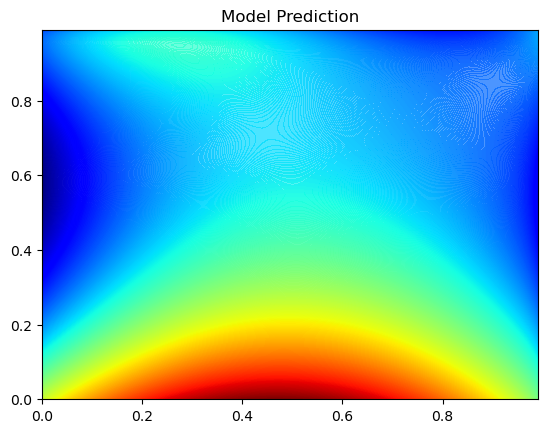

In [7]:
import matplotlib.pyplot as plt

x_test = torch.linspace(xmin, xmax, steps=100)
y_test = torch.linspace(ymin, ymax, steps=100)
x_mesh, y_mesh = torch.meshgrid(x_test, y_test)
grid_data = torch.cat([x_mesh.reshape(-1, 1), y_mesh.reshape(-1, 1)], dim=1)

result_exact = torch.exp(-torch.pi * grid_data[:, 0]) * torch.sin(torch.pi * grid_data[:, 1])
result_model = model(grid_data).detach().numpy()

# Reshape results for plotting
result_exact = result_exact.reshape(100, 100)
result_model = result_model.reshape(100, 100)

plt.contourf(y_test, x_test, result_exact, levels=1000, cmap="jet", alpha=0.7, label="Exact")
plt.title("Exact Solution")
plt.show()
plt.contourf(x_test, y_test, result_model, levels=1000, cmap="jet", alpha=0.7, label="Model")
plt.title("Model Prediction")
plt.show()